In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/My Drive/test_colab/ml_project2/src

/content/gdrive/My Drive/test_colab/ml_project2/src


In [4]:
! git pull

remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5 (delta 1), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/salimbeni1/ml_project2
   634a403..ba9c2ab  main       -> origin/main
Updating 634a403..ba9c2ab

^C


In [3]:
!ls ../data

test  train


In [4]:
import sound_processing as sp

In [5]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import glob

In [6]:
#sample_rate, samples = wavfile.read('../data/Pn_GVA_Cases/Pn_GVA_Ca10/audio/Pn_GVA_Ca10_P1.wav')
#sp.show_spec_from_sample(samples , sample_rate)

In [7]:
features, diseases, positions, controls, frequences, patientnbs = sp.get_feature_and_labels( '../data/train/*/*/*/'  ) # both control and case

indx = 100 # example on sample nb100
print(features[indx] ,diseases[indx] , positions[indx] , controls[indx] , frequences[indx] , patientnbs[indx])

 23%|██▎       | 121/532 [00:34<02:27,  2.78it/s]

KeyboardInterrupt: ignored

In [8]:
featuresT, diseasesT, positionsT, controlsT, frequencesT, patientnbsT = sp.get_feature_and_labels( '../data/test/*/*/*/'  ) # both control and case

indx = 2 # example on sample nb100
print(featuresT[indx] ,diseasesT[indx] , positionsT[indx] , controlsT[indx] , frequencesT[indx] , patientnbsT[indx])


100%|██████████| 70/70 [00:45<00:00,  1.55it/s]

[[ 5.9706962e-04  6.7813793e-04  7.3362316e-04 ...  1.4544959e-03
   1.4135670e-03  1.3664027e-03]
 [ 4.5743445e-03  4.5443438e-03  4.5135305e-03 ...  6.3816099e-03
   6.5101506e-03  6.6417879e-03]
 [ 1.0954206e-02  1.1060468e-02  1.1153707e-02 ... -2.0139068e-04
  -1.3030520e-04 -6.7431603e-05]
 [-1.6394678e-03 -1.6848879e-03 -1.7421885e-03 ... -2.8045769e-03
  -2.7617300e-03 -2.7151031e-03]] Pn P3 Ca 22050 30


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, ZeroPadding2D, Dropout, BatchNormalization, Activation
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger, RemoteMonitor, TensorBoard, ReduceLROnPlateau
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

In [10]:
import keras.backend as K
def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
#position = 'P5'
#indx = positions == position

indx = np.arange(positions.shape[0])

y_train = (controls[indx] == 'Ca')
x_train = features[indx]

y_train_big = []
x_train_big = []
train_patientnb_big = []

for i, j, p in zip(x_train, y_train, patientnbs):
  for subsample in i:
    y_train_big.append(j )
    x_train_big.append(subsample )
    train_patientnb_big.append(p)

y_train = np.array(y_train_big)
x_train = np.array(x_train_big)
train_patientnb_big = np.array(train_patientnb_big)

print(y_train.shape ,x_train.shape ,train_patientnb_big.shape)

In [35]:

#indx = positions == position
indx = np.arange(positionsT.shape[0])

y_test = (controlsT[indx] == 'Ca')
x_test = featuresT[indx]


y_test_big = []
x_test_big = []
test_patientnb_big = []
test_position_big = []

for i, j , p ,pos in zip(x_test, y_test, patientnbsT, positionsT ):
  for subsample in i:
    y_test_big.append(j )
    x_test_big.append(subsample )
    test_patientnb_big.append(p)
    test_position_big.append(pos)

y_test = np.array(y_test_big)
x_test = np.array(x_test_big)
test_patientnb_big = np.array(test_patientnb_big)
test_position_big = np.array(test_position_big)

print(y_test.shape ,x_test.shape , test_patientnb_big.shape)


(1256,) (1256, 110250) (1256,)


In [36]:
x_train_final = []
x_test_final = []

#for sample in x_train:
#  x_train_final.append(sp.features_extraction(sample,22050,'stft'))

for sample in x_test:
  x_test_final.append(sp.features_extraction(sample,22050,'stft'))  

#x_train_final = np.array(x_train_final)[:,:,:,np.newaxis]
x_test_final = np.array(x_test_final)[:,:,:,np.newaxis]

print(x_test_final.shape)
#print(y_train.shape)

(1256, 150, 216, 1)


In [37]:
#copy

#XTr = x_train_final.copy()
XTe = x_test_final.copy()
#YTr = y_train.astype(int).copy()
YTe = y_test.astype(int).copy()

print(XTe.shape)
print(YTe.shape)


(1256, 150, 216, 1)
(1256,)


In [38]:
#y_train = to_categorical(YTr)
y_test = to_categorical(YTe)

#print(y_train,y_train.shape)

In [ ]:
shuffle_indices = np.random.permutation(np.arange(y_train.shape[0]))
y_train = y_train[shuffle_indices]  # rearranges the y_train based on the shuffled indices
XTr = XTr[shuffle_indices]  # rearranges the x_train based on the shuffled indices
train_patientnb_big = train_patientnb_big[shuffle_indices]

In [ ]:
print(y_train)

In [39]:
shape = XTe.shape[1:]
train_batch_size = 32
#train_steps = XTr.shape[0]//train_batch_size # need to specify the number of steps since the data generator outputs continuously


x_test = XTe.astype('float32') # not sure why I do this but let's keep it for now
#x_train = XTr.astype('float32')

train_generator = ImageDataGenerator(width_shift_range=20,
                            #height_shift_range=4,
                            #zoom_range=[1/1.3, 1.3],
                            
                            )


train_generator.fit(x_test) #apply the augmetnation to train data

train_datagen = train_generator.flow(x_test, y_test, batch_size=train_batch_size) # creates the mii batch flow



In [40]:
model = Sequential()

model.add(Convolution2D(20, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Convolution2D(50, (3, 3), activation='relu', padding='same', input_shape=shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Flatten())
dense1_unit = 25
model.add(Dense(dense1_unit, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

sgd = optimizers.SGD(lr=0.00004, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy',f1])
#model.compile(optimizer=sgd, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])

#Callbacks

'''
checkpointer = ModelCheckpoint(monitor='val_accuracy', # automatically saves the model 
                               mode='auto', 
                               filepath='../XXX'+position+'_D'+str(dense1_unit)+'.h5',
                               verbose=1,
                               save_best_only=True,
                               save_freq = 'epoch'
                              )
                            '''

csv_logger = CSVLogger('../test_model.txt') # saves the output log in csv


#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, # can be used to reduce the learning rate once the model stops learning
                       #min_delta=0.001, cooldown=1,
                       #verbose=1, patience=10,
                       # min_lr=4.0e-5)

#FitTheModel
'''
history = model.fit_generator(train_datagen,
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data=(x_test, y_test),
                              #callbacks= [checkpointer]
                              )'''
                              
                              

'\nhistory = model.fit_generator(train_datagen,\n                              steps_per_epoch=train_steps,\n                              epochs=50,\n                              validation_data=(x_test, y_test),\n                              #callbacks= [checkpointer]\n                              )'

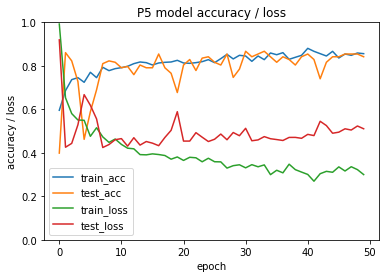

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(position+' model accuracy / loss')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train_acc', 'test_acc','train_loss','test_loss'], loc='lower left')
plt.ylim(ymax = 1, ymin = 0)
plt.show()


In [ ]:
!ls ../

data  P1_D25.h5  P2_D25.h5  P3_D25.h5  P8_D25.h5  README.md  src  test_model.h5


In [ ]:
print(x_test.shape, y_test.shape)

In [ ]:
model.load_weights('../P1_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 8ms/step - loss: 0.3566 - accuracy: 0.8782 - f1: 0.8813
[0.35656261444091797, 0.8782051205635071, 0.8812500238418579]
23/23 [==============================] - 0s 10ms/step - loss: 0.3562 - accuracy: 0.8390 - f1: 0.8390
[0.35621216893196106, 0.8390177488327026, 0.8389710187911987]


In [ ]:
model.load_weights('../P2_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

6/6 [==============================] - 0s 8ms/step - loss: 0.4654 - accuracy: 0.8793 - f1: 0.8906
[0.4653988182544708, 0.8793103694915771, 0.890625]
25/25 [==============================] - 0s 10ms/step - loss: 0.3530 - accuracy: 0.8440 - f1: 0.8500
[0.3529934883117676, 0.8439531922340393, 0.8499999046325684]


In [ ]:
model.load_weights('../P3_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 8ms/step - loss: 0.4525 - accuracy: 0.8630 - f1: 0.8750
[0.4524646997451782, 0.8630136847496033, 0.875]
23/23 [==============================] - 0s 10ms/step - loss: 0.3886 - accuracy: 0.8249 - f1: 0.8125
[0.388602077960968, 0.8248587846755981, 0.8124999403953552]


In [ ]:
model.load_weights('../P4_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 8ms/step - loss: 0.6246 - accuracy: 0.8618 - f1: 0.8687
[0.6245535016059875, 0.8618420958518982, 0.8687499761581421]
24/24 [==============================] - 0s 10ms/step - loss: 0.3446 - accuracy: 0.8360 - f1: 0.8370
[0.34460458159446716, 0.8359788656234741, 0.83697909116745]


In [ ]:
model.load_weights('../P5_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 9ms/step - loss: 0.5127 - accuracy: 0.8671 - f1: 0.8687
[0.5127297043800354, 0.8670886158943176, 0.8687499761581421]
22/22 [==============================] - 0s 11ms/step - loss: 0.3270 - accuracy: 0.8292 - f1: 0.8317
[0.32703477144241333, 0.829197108745575, 0.8317306637763977]


In [ ]:
model.load_weights('../P6_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

6/6 [==============================] - 0s 8ms/step - loss: 0.4505 - accuracy: 0.8466 - f1: 0.7691
[0.45051729679107666, 0.8466257452964783, 0.7690972685813904]
21/21 [==============================] - 0s 10ms/step - loss: 0.3554 - accuracy: 0.8418 - f1: 0.8419
[0.35542550683021545, 0.841791033744812, 0.8418650031089783]


In [ ]:
model.load_weights('../P7_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 8ms/step - loss: 0.1254 - accuracy: 0.9740 - f1: 0.9692
[0.12539531290531158, 0.9740259647369385, 0.9692307710647583]
24/24 [==============================] - 0s 10ms/step - loss: 0.1629 - accuracy: 0.9367 - f1: 0.9351
[0.16294337809085846, 0.936675488948822, 0.9351325631141663]


In [ ]:
model.load_weights('../P8_D25.h5')

print(model.evaluate(x_test, y_test))
print(model.evaluate(x_train, y_train))

5/5 [==============================] - 0s 9ms/step - loss: 0.1846 - accuracy: 0.9935 - f1: 0.9937
[0.1845911741256714, 0.9934640526771545, 0.9937499761581421]
26/26 [==============================] - 0s 10ms/step - loss: 0.3284 - accuracy: 0.8712 - f1: 0.8697
[0.3283524811267853, 0.8711656332015991, 0.8697114586830139]


In [95]:
stat = [[0.35656261444091797, 0.8782051205635071, 0.8812500238418579],
        [0.4653988182544708, 0.8793103694915771, 0.890625],
        [0.4524646997451782, 0.8630136847496033, 0.875],
        [0.6245535016059875, 0.8618420958518982, 0.8687499761581421],
        [0.5127297043800354, 0.8670886158943176, 0.8687499761581421],
        [0.45051729679107666, 0.8466257452964783, 0.7690972685813904],
        [0.12539531290531158, 0.9740259647369385, 0.9692307710647583],
        [0.1845911741256714, 0.9934640526771545, 0.9937499761581421]]
stat = np.array(stat)
'''
stat = [[0.5312677621841431, 0.7380573153495789, 0.7406250238418579],
        [0.551033616065979, 0.7969745397567749, 0.80078125],
        [0.4868663251399994, 0.8208598494529724, 0.819531261920929],
        [0.48064538836479187, 0.8272293210029602, 0.828125],
        [0.6950857043266296, 0.7929936051368713, 0.796875],
        [0.5611410140991211, 0.831210196018219, 0.8343750238418579],
        [0.8402006030082703, 0.6966560482978821, 0.699999988079071],
        [0.3759962320327759, 0.8503184914588928, 0.8531249761581421]]
stat = np.array(stat)'''

'\nstat = [[0.5312677621841431, 0.7380573153495789, 0.7406250238418579],\n        [0.551033616065979, 0.7969745397567749, 0.80078125],\n        [0.4868663251399994, 0.8208598494529724, 0.819531261920929],\n        [0.48064538836479187, 0.8272293210029602, 0.828125],\n        [0.6950857043266296, 0.7929936051368713, 0.796875],\n        [0.5611410140991211, 0.831210196018219, 0.8343750238418579],\n        [0.8402006030082703, 0.6966560482978821, 0.699999988079071],\n        [0.3759962320327759, 0.8503184914588928, 0.8531249761581421]]\nstat = np.array(stat)'

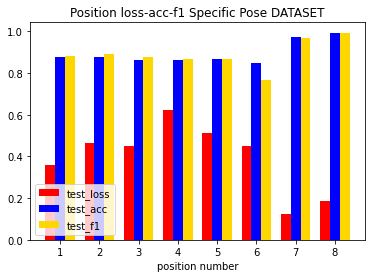

In [96]:
for i in np.arange(stat.shape[0]):
  plt.bar(i+1 + -0.25, stat[i][0], color = 'r', width = 0.25)
  plt.bar(i+1 + 0., stat[i][1], color = 'b', width = 0.25)
  plt.bar(i+1 + 0.25, stat[i][2], color = 'gold', width = 0.25)

plt.title('Position loss-acc-f1 Specific Pose DATASET')
plt.legend(['test_loss', 'test_acc','test_f1'], loc='lower left')
plt.xlabel('position number')
plt.show()

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [41]:
for pos in range(8):
  model.load_weights('../P'+str(pos+1)+'_D25.h5')
  print('Pos'+str(pos+1),model.evaluate(x_test, y_test))

40/40 [==============================] - 1s 13ms/step - loss: 0.5313 - accuracy: 0.7381 - f1: 0.7406
Pos1 [0.5312677621841431, 0.7380573153495789, 0.7406250238418579]
40/40 [==============================] - 1s 13ms/step - loss: 0.5510 - accuracy: 0.7970 - f1: 0.8008
Pos2 [0.551033616065979, 0.7969745397567749, 0.80078125]
40/40 [==============================] - 1s 13ms/step - loss: 0.4869 - accuracy: 0.8209 - f1: 0.8195
Pos3 [0.4868663251399994, 0.8208598494529724, 0.819531261920929]
40/40 [==============================] - 1s 13ms/step - loss: 0.4806 - accuracy: 0.8272 - f1: 0.8281
Pos4 [0.48064538836479187, 0.8272293210029602, 0.828125]
40/40 [==============================] - 1s 13ms/step - loss: 0.6951 - accuracy: 0.7930 - f1: 0.7969
Pos5 [0.6950857043266296, 0.7929936051368713, 0.796875]
40/40 [==============================] - 1s 13ms/step - loss: 0.5611 - accuracy: 0.8312 - f1: 0.8344
Pos6 [0.5611410140991211, 0.831210196018219, 0.8343750238418579]
40/40 [=====================

In [42]:
x_test_ = x_test.copy()
y_test_ = y_test.copy()
p_test_ = test_patientnb_big.copy()
pos_test_ = test_position_big.copy()

print(x_test_.shape,y_test_.shape,p_test_.shape,pos_test_.shape)


(1256, 150, 216, 1) (1256, 2) (1256,) (1256,)


In [47]:
print(np.unique(patientnbsT))
unique_patient = np.unique(p_test_)

['12' '14' '18' '30' '40' '43' '46' '65' '7']


In [44]:
x_test_7 = x_test_[pos_test_ == 'P7']
y_test_7 = y_test_[pos_test_ == 'P7']

model.load_weights('../P7_D25.h5')
print('Pos7',model.evaluate(x_test_7, y_test_7))

5/5 [==============================] - 0s 24ms/step - loss: 0.1254 - accuracy: 0.9740 - f1: 0.9692
Pos7 [0.1253952980041504, 0.9740259647369385, 0.9692307710647583]


In [102]:
position_weights = [1,1,1,1,1,1,5,5]

y_pred_patient = []
y_expc_patient = []

for patient in unique_patient:
  x_test_patient = x_test_[p_test_ == patient]
  y_test_patient = y_test_[p_test_ == patient][0] # all the same
  pos_test_patient = pos_test_[p_test_ == patient]

  pred_patient = []
  for pos in np.unique(pos_test_patient):
    model.load_weights('../'+str(pos)+'_D25.h5')
    pred = model.predict(x_test_patient[pos_test_patient == pos])
    for i in range(position_weights[int(pos[1])-1]):
      pred_patient.append(np.mean(pred,axis=0))
    
  y_pred_patient.append(np.mean(pred_patient,axis=0))
  y_expc_patient.append(y_test_patient)
  print('patient',patient ,' predicted:', np.mean(pred_patient,axis=0) , 'expected:' , y_test_patient)

y_pred_patient = np.array(y_pred_patient)
y_expc_patient = np.array(y_expc_patient)


patient 12  predicted: [0.87132585 0.128674  ] expected: [1. 0.]
patient 14  predicted: [0.8376091  0.16239083] expected: [1. 0.]
patient 18  predicted: [0.927456   0.07254402] expected: [1. 0.]
patient 30  predicted: [0.1218483  0.87815154] expected: [0. 1.]
patient 40  predicted: [0.0402527 0.9597473] expected: [0. 1.]
patient 43  predicted: [0.01850494 0.9814951 ] expected: [0. 1.]
patient 46  predicted: [0.01710532 0.9828947 ] expected: [0. 1.]
patient 65  predicted: [0.4448742  0.55512583] expected: [0. 1.]
patient 7  predicted: [0.76703644 0.23296352] expected: [1. 0.]


In [103]:
print('f1:', f1(y_expc_patient , y_pred_patient ) )

f1: tf.Tensor(1.0, shape=(), dtype=float32)
